## Library imports


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [103]:
URL_BASE = 'https://git.imp.fu-berlin.de/ipa-team/ipa_data/-/raw/master/Project%209/S4/'

def load_csv_from_gitlab(csv_name, url_base=URL_BASE):
  import requests
  from io import StringIO

  def load_csv_from(url):
	  return pd.read_csv(StringIO(requests.get(url).text), index_col=0)  
	
  return load_csv_from(URL_BASE + csv_name)

In [104]:
class Object(object):
  def items(self):
    return self.__dict__.items()

## Project Task 1 - Import and understand the data

*   Import the available data into your workspace (e.g. Python or a Python Jupyter notebook). 
*   Create corresponding tables for the available files. You can use any Database-(like) system or Pandas DataFrames.
*   You can restrict the import and the following tasks to one sample (sub-study) only!
*   The chosen samples can also differ between the tasks.
*   If you need to perform imputation, implement a suitable strategy.


In [105]:
def parse_date(df):
  df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [106]:
df = Object()
df.calls_in_dur = load_csv_from_gitlab('S4 calls_in_duration_long.csv')
parse_date(df.calls_in_dur)
df.calls_in_freq = load_csv_from_gitlab('S4 calls_in_frequency_long.csv')
parse_date(df.calls_in_freq)
df.calls_out_dur = load_csv_from_gitlab('S4 calls_out_duration_long.csv')
parse_date(df.calls_out_dur)
df.calls_out_freq = load_csv_from_gitlab('S4 calls_out_frequency_long.csv')
parse_date(df.calls_out_freq)
df.convo_dur = load_csv_from_gitlab('S4 convo_duration_long.csv')
parse_date(df.convo_dur)
df.convo_freq = load_csv_from_gitlab('S4 convo_frequency_long.csv')
parse_date(df.convo_freq)
df.sms_in_freq = load_csv_from_gitlab('S4 sms_in_frequency_long.csv')
parse_date(df.sms_in_freq)
df.sms_in_len = load_csv_from_gitlab('S4 sms_in_length_long.csv')
parse_date(df.sms_in_len)
df.sms_out_freq = load_csv_from_gitlab('S4 sms_out_frequency_long.csv')
parse_date(df.sms_out_freq)
df.sms_out_len = load_csv_from_gitlab('S4 sms_out_length_long.csv')
parse_date(df.sms_out_len)
df.behaviors = load_csv_from_gitlab('S4 social_behaviors_wide.csv')

In [107]:
def check_for_nan(df):
  res = df.isnull().sum()
  return res[res != 0]

def check_dfs_for_nan(dfs):
  for name, df in dfs.items():
    nans = check_for_nan(df)
    if len(nans):
      print(f'Nan values in: {name}\n{nans}')

check_dfs_for_nan(df)

Nan values in: behaviors
convo_num_avg_daily         7
convo_num_avg_friday      149
convo_num_avg_monday      166
convo_num_avg_saturday    168
convo_num_avg_sunday      167
                         ... 
bfi_e                     144
bfi_a                     144
bfi_c                     144
bfi_n                     144
bfi_o                     144
Length: 147, dtype: int64


In [108]:
df.sms_out_freq

userid       date  sums_24hours
31        u0011@psychpulse 2016-09-15             1
32        u0011@psychpulse 2016-09-16            32
33        u0011@psychpulse 2016-09-17            16
34        u0011@psychpulse 2016-09-18             5
45        u0021@psychpulse 2016-09-15             7
...                    ...        ...           ...
3370  u0706@psychpulsesp17 2017-02-17            25
3371  u0706@psychpulsesp17 2017-02-18            16
3372  u0706@psychpulsesp17 2017-02-19            11
3373  u0706@psychpulsesp17 2017-02-20            23
3374  u0706@psychpulsesp17 2017-02-21             0

[1410 rows x 3 columns]

In [109]:
def visualize_nans(df):
  sns.set(rc={'figure.figsize':(30,5)})
  plt.xticks(rotation=90)
  plot = sns.lineplot(data=df).set_title('Number of NaN Values in behaviors dataframe')
  sns.set(rc={'figure.figsize':(10,5)})  

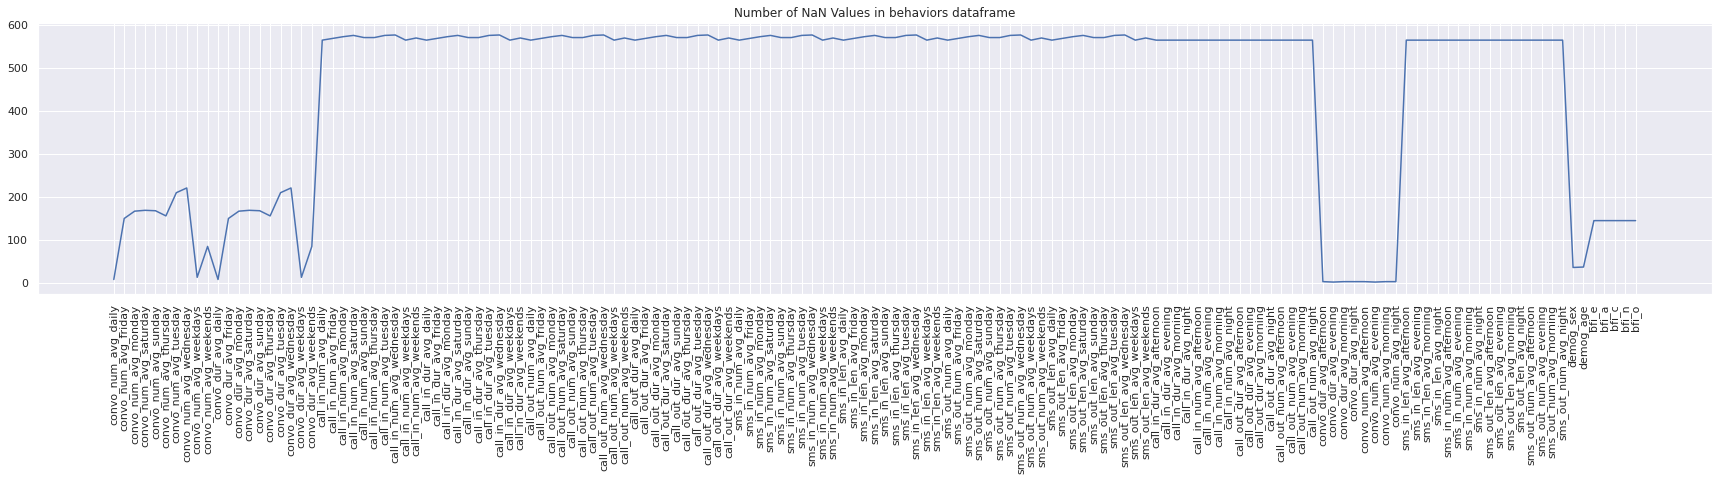

In [110]:
visualize_nans(check_for_nan(df.behaviors))

In [111]:
# Delte rows with nan values in big five answer column, since this is the target label, so it can not be imputed (but only predicted)
df.behaviors.dropna(subset=["bfi_e"], inplace=True)
check_for_nan(df.behaviors)

convo_num_avg_friday       102
convo_num_avg_monday       123
convo_num_avg_saturday     124
convo_num_avg_sunday       122
convo_num_avg_thursday     109
                          ... 
sms_out_num_avg_evening    455
sms_out_num_avg_morning    455
sms_out_num_avg_night      455
demog_sex                   16
demog_age                   17
Length: 134, dtype: int64

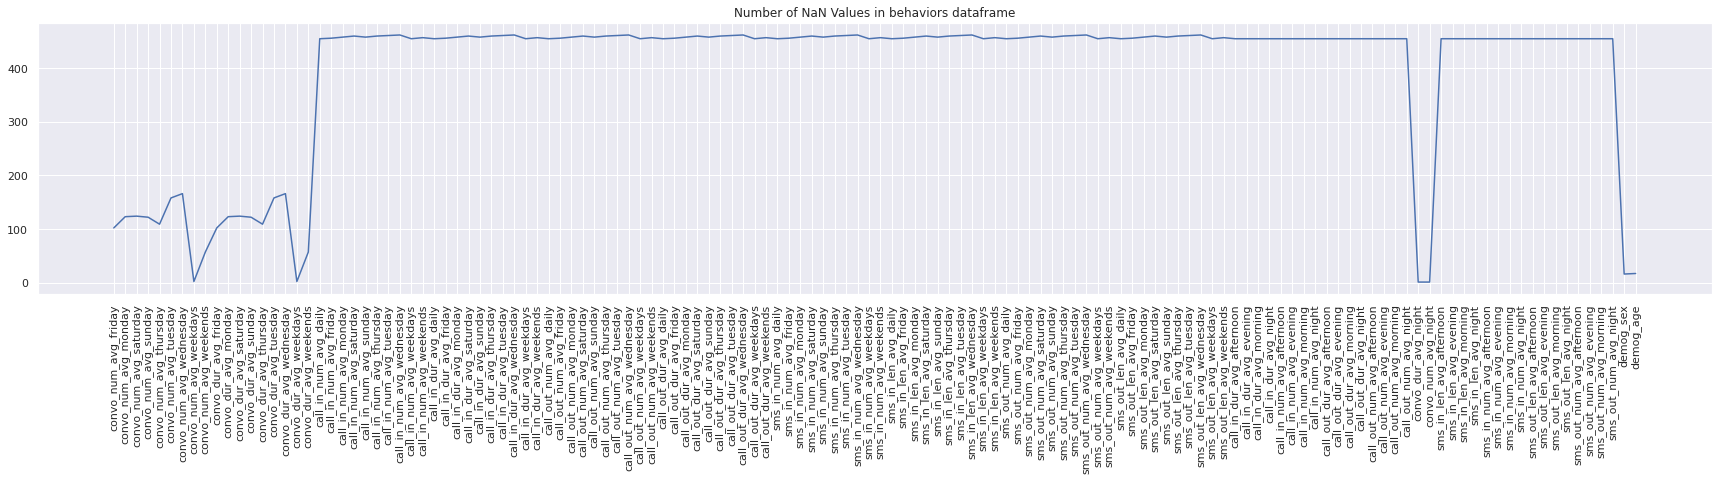

In [112]:
visualize_nans(check_for_nan(df.behaviors))

# Project Task 2 - Are there individual differences in the daily social behavior?

*   Reproduce Table 2 from the Harari paper. You can limit this analysis to one of the samples.
*   Create a visualization of a user’s time-series for a particular measurement (e.g. CALL IN FREQ) that shows a large variance and one for another user that shows a small variance.

In [113]:
!pip install pingouin


Currently, this figure is not reproducible in Python using the pingouin package. While the implementation of the pingouin.intraclass_corr follows the implementation of ICC from the R Psych library, it does not use linear mixed effect but regular ANOVA. Therefore, the package only accepts complete-case data wo missing values. When removing missing values with na_policy "omit", not enough data points remain. 

In [114]:
import pingouin as pg


Missing data problem: 

In [115]:
tables = dir(df)[-12:]

tables = ["convo_freq", "convo_dur", "calls_in_freq", "calls_in_dur", "calls_out_freq", "calls_out_dur", "sms_in_freq", "sms_in_len", "sms_out_freq", "sms_out_len"]
print(len(tables))

table2 = pd.DataFrame(index = ["Betw-pers-var", "Betw-pers-conf", "Mean-cons", "Mean-cons-conf", "individuals-incl"])

for elem in tables:
  table = getattr(df, elem)
  table["date"] = table["date"].astype("str")
  #table["usercount"] = table["userid"].value_count()

  #remove date 2017-02-08 since it only has one data point
  table = table[table["date"] != "2017-02-08"]

  piv_table = table.pivot(index = "userid", columns = "date")

  red_table = table[table["date"].isin(["2016-09-16", "2016-09-17", "2016-09-18", "2016-09-19", "2016-09-20", "2016-09-21", "2016-09-22", "2016-09-23"])]

  idcount = red_table["userid"].value_counts(sort = False)>=8
  include_indivs = list(idcount.index[idcount])


  red_table = red_table[red_table["userid"].isin(include_indivs)]

  red_pivot = red_table.pivot(index = "userid", columns = "date")


  result = pg.intraclass_corr(data = red_table, raters = "date", targets = "userid", ratings = "sums_24hours", nan_policy = "omit")
  
  table2[elem] = [float(result[result["Type"] == "ICC1"]["ICC"]), list(result[result["Type"] == "ICC1"]["CI95%"]),float(result[result["Type"] == "ICC3k"]["ICC"]), list(result[result["Type"] == "ICC3k"]["CI95%"]), red_pivot.shape]

10


In [116]:
table2

convo_freq  ...     sms_out_len
Betw-pers-var           0.682845  ...         0.49289
Betw-pers-conf    [[0.61, 0.75]]  ...  [[0.39, 0.61]]
Mean-cons               0.946983  ...        0.888226
Mean-cons-conf    [[0.93, 0.96]]  ...  [[0.84, 0.93]]
individuals-incl         (89, 8)  ...         (58, 8)

[5 rows x 10 columns]

In [117]:
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import plot_components

In [118]:
cif = getattr(df, "calls_in_freq")
table = table[table["date"] != "2017-02-08"]
piv_table = table.pivot(index = "date", columns = "userid")


counts = piv_table.count()
#maximum number of data points for time series: 13, 12
max_counts = counts[counts == 12]
max_counts_names = max_counts.index.get_level_values("userid")
max_counts_names12 = ['u0022@psychpulse', 'u0107@psychpulse', 'u0138@psychpulse',
       'u0159@psychpulse', 'u0166@psychpulse', 'u0181@psychpulse',
       'u0185@psychpulsesp17', 'u0213@psychpulsesp17', 'u0246@psychpulse',
       'u0278@psychpulse', 'u0289@psychpulse', 'u0312@psychpulse',
       'u0317@psychpulse', 'u0348@psychpulse', 'u0386@psychpulse',
       'u0393@psychpulse', 'u0403@psychpulse', 'u0439@psychpulse',
       'u0468@psychpulse', 'u0495@psychpulse', 'u0539@psychpulse',
       'u0579@psychpulse', 'u0583@psychpulse', 'u0595@psychpulse',
       'u0602@psychpulsesp17', 'u0606@psychpulsesp17', 'u0728@psychpulse',
       'u0737@psychpulse', 'u0740@psychpulse', 'u0776@psychpulse',
       'u0790@psychpulse', 'u0802@psychpulse', 'u0829@psychpulse',
       'u0832@psychpulse', 'u0896@psychpulse', 'u0928@psychpulse',
       'u0939@psychpulse', 'u0944@psychpulse']
max_counts_names13 = ["u0489@psychpulsesp17", "u0605@psychpulsesp17"]

variance = piv_table.var()
variance_selected = variance[variance.index.get_level_values("userid").isin(max_counts_names12) ]
#variances for 13: 13039.715751, 33745.390301

min_var_larger0 = min(variance_selected[variance_selected > 0])
min_name = variance_selected.index.get_level_values("userid")[variance_selected == min_var_larger0]
max_var = max(variance_selected)
max_name = variance_selected.index.get_level_values("userid")[variance_selected == max_var]


sequences = table[table["userid"].isin(max_counts_names13)]
piv_sequences = sequences.pivot(index = "date", columns = "userid")
piv_sequences.columns = piv_sequences.columns.get_level_values("userid")
print(piv_sequences)


userid      u0489@psychpulsesp17  u0605@psychpulsesp17
date                                                  
2017-02-09              0.000000            194.562937
2017-02-10             72.000000            565.059524
2017-02-11             89.750000            133.500000
2017-02-12            241.600000            448.300000
2017-02-13            155.000000            401.666667
2017-02-14            169.000000            206.333333
2017-02-15             10.000000            218.450000
2017-02-16              0.000000            144.000000
2017-02-17             39.500000            239.583333
2017-02-18             61.000000              0.000000
2017-02-19            382.647619              0.000000
2017-02-20             31.000000              0.000000
2017-02-21              0.000000              0.000000


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0, 0.5, 'calls freq')

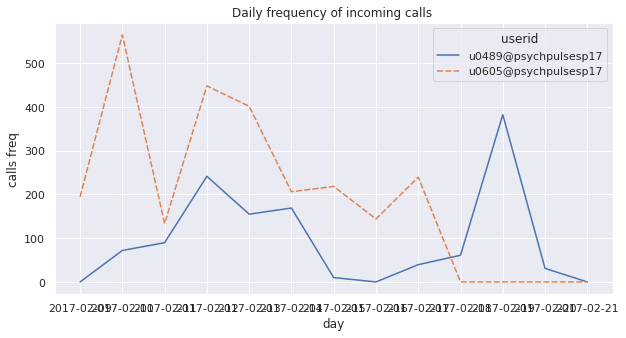

In [119]:
fig = plt.figure(figsize = (10,5))
ax = sns.lineplot(data = piv_sequences)
plt.title('Daily frequency of incoming calls ')
plt.xlabel('day')
plt.ylabel('calls freq')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


Index(['2017-02-09', '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
       '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18',
       '2017-02-19', '2017-02-20', '2017-02-21'],
      dtype='object', name='date')
            ds           y
0   2017-02-09    0.000000
1   2017-02-10   72.000000
2   2017-02-11   89.750000
3   2017-02-12  241.600000
4   2017-02-13  155.000000
5   2017-02-14  169.000000
6   2017-02-15   10.000000
7   2017-02-16    0.000000
8   2017-02-17   39.500000
9   2017-02-18   61.000000
10  2017-02-19  382.647619
11  2017-02-20   31.000000
12  2017-02-21    0.000000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


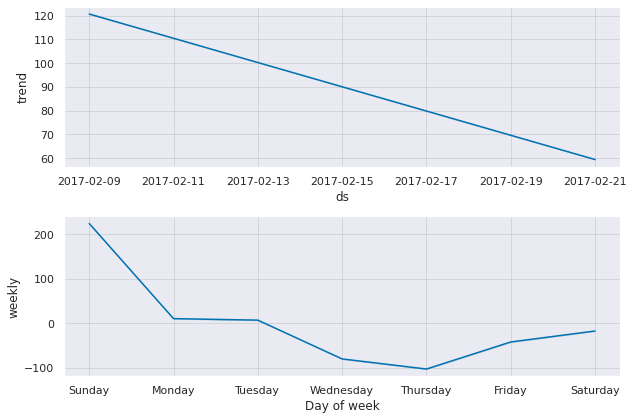

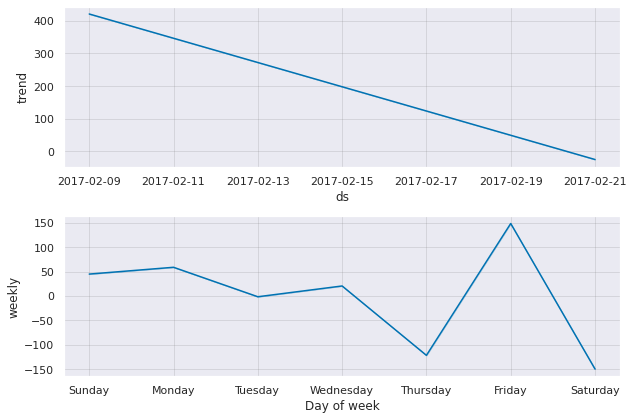

In [120]:
print(piv_sequences['u0489@psychpulsesp17'].index)
u04 = pd.DataFrame({"ds": list(piv_sequences.index),"y": list(piv_sequences['u0489@psychpulsesp17'])})
u06 = pd.DataFrame({"ds": list(piv_sequences.index),"y": list(piv_sequences['u0605@psychpulsesp17'])})

print(u04)

m = Prophet(weekly_seasonality=True )
m.fit(u04)
forecast = m.predict(u04)
p1 = plot_components(m, forecast)
p1.savefig("u0489@psychpulsesp17.png")

m = Prophet(weekly_seasonality=True) 
m.fit(u06)
forecast = m.predict(u06)
p2 = plot_components(m, forecast)
p2.savefig("u0605@psychpulsesp17.png")

In [121]:
variance.index.get_level_values("userid")

Index(['u0004@psychpulsesp17', 'u0011@psychpulse', 'u0017@psychpulsesp17',
       'u0021@psychpulse', 'u0022@psychpulse', 'u0033@psychpulse',
       'u0039@psychpulsesp17', 'u0052@psychpulse', 'u0065@psychpulse',
       'u0068@psychpulse',
       ...
       'u0922@psychpulse', 'u0928@psychpulse', 'u0939@psychpulse',
       'u0944@psychpulse', 'u0945@psychpulse', 'u0994@psychpulse',
       'u0997@psychpulse', 'u0998@psychpulse', 'u1022@psychpulse',
       'u1024@psychpulse'],
      dtype='object', name='userid', length=153)

Still missing: Users time-series

# Project Task 3 - Which behavioral dispositions are related to personality traits?

*    Analyze the data such that you can generate similar results as described in section “Behavioral Sociability and Self-Reported Personality Traits”. You can focus on the correlations between sensed social behavior tendencies and Extraversion. Compare your results to the once from table 7.
*    If there is time, repeat the analysis for the other Big Five traits.
*    You do not need to follow the paper with regards to the analysis techniques that the authors used.

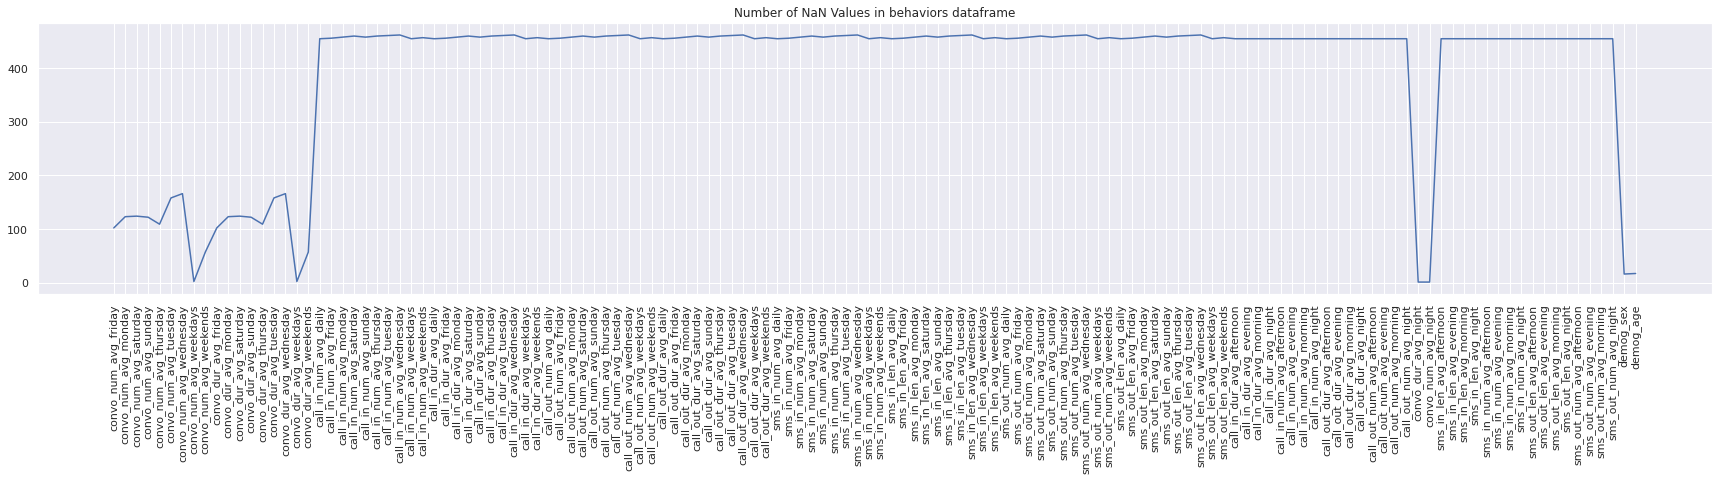

In [122]:
visualize_nans(check_for_nan(df.behaviors))

In [123]:
import scipy.stats as st
import math

In [124]:
convo_columns = ["convo_num_avg_morning", "convo_num_avg_afternoon", "convo_num_avg_evening", "convo_num_avg_night", "convo_num_avg_weekdays",  "convo_num_avg_weekends", "convo_dur_avg_morning", "convo_dur_avg_afternoon", "convo_dur_avg_evening", "convo_dur_avg_night", "convo_dur_avg_weekdays", "convo_dur_avg_weekends", "call_in_num_avg_morning", "call_in_num_avg_afternoon", "call_in_num_avg_evening", "call_in_num_avg_night", "call_in_num_avg_weekdays",  "call_in_num_avg_weekends", "call_in_dur_avg_morning", "call_in_dur_avg_afternoon", "call_in_dur_avg_evening", "call_in_dur_avg_night", "call_in_dur_avg_weekdays", "call_in_dur_avg_weekends",  "call_out_num_avg_morning", "call_out_num_avg_afternoon", "call_out_num_avg_evening", "call_out_num_avg_night", "call_out_num_avg_weekdays",   "call_out_num_avg_weekends", "call_out_dur_avg_morning", "call_out_dur_avg_afternoon", "call_out_dur_avg_evening", "call_out_dur_avg_night", "call_out_dur_avg_weekdays",   "call_out_dur_avg_weekends", "sms_in_num_avg_morning", "sms_in_num_avg_afternoon", "sms_in_num_avg_evening", "sms_in_num_avg_night", "sms_in_num_avg_weekdays",   "sms_in_num_avg_weekends", "sms_in_len_avg_morning", "sms_in_len_avg_afternoon", "sms_in_len_avg_evening", "sms_in_len_avg_night", "sms_in_len_avg_weekdays",   "sms_in_len_avg_weekends", "sms_out_num_avg_morning", "sms_out_num_avg_afternoon", "sms_out_num_avg_evening", "sms_out_num_avg_night", "sms_out_num_avg_weekdays",  "sms_out_num_avg_weekends",  "sms_out_len_avg_morning", "sms_out_len_avg_afternoon", "sms_out_len_avg_evening", "sms_out_len_avg_night", "sms_out_len_avg_weekdays", "sms_out_len_avg_weekends"]
psych_columns = ["bfi_e", 	"bfi_a", 	"bfi_c", 	"bfi_n", 	"bfi_o"]


rownames = ["morning convofreq", "afternoon convofreq", "evening convofreq", "night convofreq", "weekday convofreq", "weekend convofreq", "morning convodur", "afternoon convodur", "evening convodur", "night convodur",  "weekday convodur", "weekend convodur", "morning callinfreq", "afternoon callinfreq", "evening callinfreq", "night callinfreq", "weekday callinfreq", "weekend callinfreq", "morning callindur", "afternoon callindur", "evening callindur", "night callindur", "weekday callindur", "weekend callindur", "morning calloutfreq", "afternoon calloutfreq", "evening calloutfreq", "night calloutfreq", "weekday calloutfreq", "weekend calloutfreq", "morning calloutdur", "afternoon calloutdur", "evening calloutdur", "night calloutdur", "weekday calloutdur", "weekend calloutdur", "morning textinfreq", "afternoon textinfreq", "evening textinfreq", "night textinfreq", "weekday textinfreq", "weekend textinfreq", "morning textinlen", "afternoon textinlen", "evening textinlen", "night textinlen", "weekday textinlen", "weekend textinlen", "morning textoutfreq", "afternoon textoutfreq", "evening textoutfreq", "night textoutfreq", "weekday textoutfreq", "weekend textoutfreq", "morning textoutlen", "afternoon textoutlen", "evening textoutlen", "night textoutlen", "weekday textoutlen", "weekend textoutlen"]

colnames = ["extra.r", "extra.ci.low", "extra.ci.high", "extra.p", "agr.r", "agr.ci.low", "agr.ci.high","agr.p", "con.r", "con.ci.low","con.ci.high", "con.p", "neur.r", "neur.ci.low", "neur.ci.high", "neur.p", "ope.r", "ope.ci.low", "ope.ci.high", "ope.p"]

spearman_corr = np.zeros(shape = (len(rownames),len(colnames)))

for i in range(len(convo_columns)):
  for j in range(len(psych_columns)):
    elem = convo_columns[i]
    elem2 = psych_columns[j]
    n = len(df.behaviors[elem].dropna())
    #pc = st.pearsonr(df.behaviors[elem], df.behaviors[elem2], nan_policy = "omit")
    r, p = st.spearmanr(df.behaviors[elem], df.behaviors[elem2], nan_policy= "omit")
    ci_low = math.tanh(math.atanh(r) - 1.96/math.sqrt(n-3))
    ci_high = math.tanh(math.atanh(r) + 1.96/math.sqrt(n-3))
    spearman_corr[i,(j*4)] = r.round(2)
    spearman_corr[i,(j*4)+1] = round(ci_low, 2)
    spearman_corr[i,(j*4)+2] = round(ci_high, 2)
    spearman_corr[i,(j*4)+3] = p.round(3)


spearman_frame = pd.DataFrame(spearman_corr, index = rownames, columns = colnames)




In [125]:
spearman_frame

extra.r  extra.ci.low  ...  ope.ci.high  ope.p
morning convofreq         0.16          0.08  ...         0.03  0.248
afternoon convofreq       0.18          0.10  ...         0.10  0.712
evening convofreq         0.19          0.11  ...         0.07  0.704
night convofreq           0.16          0.08  ...         0.10  0.741
weekday convofreq         0.20          0.12  ...         0.08  0.937
weekend convofreq         0.18          0.10  ...         0.10  0.755
morning convodur          0.14          0.06  ...         0.05  0.435
afternoon convodur        0.15          0.07  ...         0.10  0.581
evening convodur          0.19          0.11  ...         0.07  0.815
night convodur            0.18          0.10  ...         0.07  0.726
weekday convodur          0.17          0.09  ...         0.08  0.988
weekend convodur          0.20          0.11  ...         0.09  0.970
morning callinfreq        0.10         -0.08  ...         0.14  0.683
afternoon callinfreq      0.20          0.02  ...         0.45  0.001
evening callinfreq        0.31          0.13  ...         0.32  0.124
night callinfreq          0.27          0.09  ...         0.24  0.514
weekday callinfreq        0.26          0.08  ...         0.35  0.049
weekend callinfreq        0.35          0.18  ...         0.32  0.122
morning callindur         0.11         -0.07  ...         0.17  0.936
afternoon callindur       0.16         -0.02  ...         0.43  0.003
evening callindur         0.33          0.16  ...         0.33  0.085
night callindur           0.28          0.10  ...         0.26  0.368
weekday callindur         0.31          0.14  ...         0.36  0.038
weekend callindur         0.32          0.14  ...         0.30  0.193
morning calloutfreq       0.23          0.05  ...         0.28  0.290
afternoon calloutfreq     0.28          0.11  ...         0.39  0.018
evening calloutfreq       0.44          0.28  ...         0.39  0.015
night calloutfreq         0.29          0.11  ...         0.20  0.796
weekday calloutfreq       0.35          0.18  ...         0.38  0.021
weekend calloutfreq       0.38          0.22  ...         0.34  0.067
morning calloutdur        0.22          0.04  ...         0.29  0.213
afternoon calloutdur      0.20          0.02  ...         0.39  0.015
evening calloutdur        0.36          0.20  ...         0.36  0.034
night calloutdur          0.26          0.09  ...         0.25  0.427
weekday calloutdur        0.26          0.08  ...         0.39  0.018
weekend calloutdur        0.31          0.14  ...         0.35  0.050
morning textinfreq        0.30          0.13  ...         0.33  0.094
afternoon textinfreq      0.35          0.18  ...         0.38  0.021
evening textinfreq        0.24          0.06  ...         0.38  0.021
night textinfreq          0.30          0.12  ...         0.40  0.010
weekday textinfreq        0.31          0.13  ...         0.43  0.003
weekend textinfreq        0.23          0.05  ...         0.35  0.050
morning textinlen         0.25          0.07  ...         0.35  0.047
afternoon textinlen       0.32          0.14  ...         0.37  0.026
evening textinlen         0.26          0.08  ...         0.45  0.001
night textinlen           0.27          0.09  ...         0.37  0.029
weekday textinlen         0.29          0.12  ...         0.43  0.003
weekend textinlen         0.22          0.03  ...         0.35  0.052
morning textoutfreq       0.35          0.18  ...         0.30  0.183
afternoon textoutfreq     0.31          0.13  ...         0.38  0.019
evening textoutfreq       0.20          0.02  ...         0.39  0.016
night textoutfreq         0.26          0.08  ...         0.39  0.016
weekday textoutfreq       0.28          0.10  ...         0.42  0.005
weekend textoutfreq       0.20          0.02  ...         0.33  0.104
morning textoutlen        0.34          0.17  ...         0.35  0.052
afternoon textoutlen      0.26          0.08  ...         0.41  0.007
evening textoutlen        0.21   

In [126]:
elem = convo_columns[0]
elem2 = psych_columns[0]

## Project Task 4 - Can we predict an individual’s personality?
*    Build a classifier predicting either an individual’s “personality category”(e.g. the most dominant trait) or the characteristic of the single traits (extraversion, agreeableness, conscientiousness, neuroticism, and openness) as numbers or categories (e.g. high or low).
*    Chose and train a suitable machine learning approach and use a train/test strategy with appropriate evaluation methods.

Todos:
* Try different imputations for missing values (with zeros and mean values)
* Feature reduction

In [127]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [128]:
df_data = df.behaviors[['call_in_num_avg_weekends', 'call_in_dur_avg_evening', 'call_out_num_avg_evening', 'call_out_dur_avg_evening','sms_out_num_avg_morning','sms_out_len_avg_morning','sms_in_num_avg_afternoon','sms_in_len_avg_afternoon','convo_dur_avg_weekends','convo_num_avg_weekdays','bfi_e']].dropna()
df_data['bfi_e_mean'] = df_data['bfi_e'] < df_data['bfi_e'].mean()
df_data['bfi_e_mean'] = df_data['bfi_e_mean'].astype(int)
df_data.drop(labels='bfi_e', axis=1,inplace=True)

## SVC

In [129]:
X = df_data.drop(labels=['bfi_e_mean'],axis=1)
y = df_data['bfi_e_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', svm.SVC(kernel = 'linear', C = 2))])
#clf = svm.SVC()
pipe.fit(X_train, y_train)

cv_results = cross_validate(pipe, X, y, cv=10, scoring=('balanced_accuracy', 'roc_auc'), return_train_score=False)
print('Results using cross-validation:')
print('Accuracy: ' + str(cv_results['test_balanced_accuracy'].mean()))
print('ROC_AUC: ' + str(cv_results['test_roc_auc'].mean()))

Results using cross-validation:
Accuracy: 0.613452380952381
ROC_AUC: 0.6583333333333334


## Random Forest

In [130]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
rf = RandomForestClassifier()
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

grid_search = RandomizedSearchCV(rf, random_grid, n_iter=1000, scoring='roc_auc', cv=skf.split(X,y), verbose=3)

grid_search.fit(X_scaled, y)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, score=0.656, total=   2.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, score=0.685, total=   2.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, score=0.622, total=   1.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.647, total=   2.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.664, total=   2.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_s

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 63.9min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f54cae2dba0>,
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                          

In [131]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 600}

In [132]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
rf = RandomForestClassifier(
    bootstrap=grid_search.best_params_['bootstrap'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    n_estimators=grid_search.best_params_['n_estimators']
    )
cv_results = cross_validate(rf, X, y, cv=10, scoring=('balanced_accuracy', 'roc_auc'), return_train_score=False)
print('Results using cross-validation:')
print('Accuracy: ' + str(cv_results['test_balanced_accuracy'].mean()))
print('ROC_AUC: ' + str(cv_results['test_roc_auc'].mean()))

Results using cross-validation:
Accuracy: 0.5713095238095238
ROC_AUC: 0.6407142857142858


## XGBoost

In [133]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)


folds = 3
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=param_comb, scoring='roc_auc', cv=skf.split(X,y), verbose=3, random_state=1001 )
grid_search = GridSearchCV(xgb, params, scoring='roc_auc', cv=skf.split(X,y), verbose=3)

grid_search.fit(X, y)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.632, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.685, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6, score=0.548, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.609, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.649, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8, score=0.554, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.579, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.643, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0, score=0.518, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6, score=0.697, total=   0.0s
[CV] colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6 


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  1.1min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f54cada6bf8>,
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.02, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=600, n_jobs=1,
                                     nthread=1, objective='binary:logistic',
                                     ra...g_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth

In [134]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 5,
 'subsample': 0.6}

Results using cross-validation:
Accuracy: 0.650595238095238
ROC_AUC: 0.6907142857142858
Results using Train test split:
Accuracy: 0.6461538461538461
ROC_AUC: 0.6461538461538462


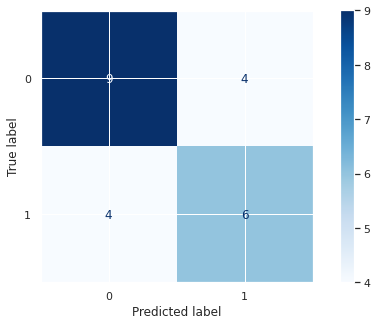

In [135]:
xgb = XGBClassifier(
    learning_rate=0.02, 
    n_estimators=600, 
    objective='binary:logistic', 
    silent=True,
    max_depth = grid_search.best_params_['max_depth'], 
    gamma = grid_search.best_params_['max_depth'], 
    subsample=grid_search.best_params_['subsample'],
    min_child_weight = grid_search.best_params_['min_child_weight'],
    colsample_bytree = grid_search.best_params_['colsample_bytree']
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
cv_results = cross_validate(xgb, X, y, cv=10,scoring=('balanced_accuracy', 'roc_auc'), return_train_score=False)
print('Results using cross-validation:')
print('Accuracy: ' + str(cv_results['test_balanced_accuracy'].mean()))
print('ROC_AUC: ' + str(cv_results['test_roc_auc'].mean()))

print('Results using Train test split:')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {score}')
print(f'ROC_AUC: {roc_score}')

plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Blues)